In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pycocotools.coco import COCO
import os
import glob
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from typing import Tuple, Any
from functools import lru_cache
from torchvision.datasets import CocoDetection
from torch.utils.data import Dataset, DataLoader
import json
from torchvision.ops import box_iou
from torchvision.ops.boxes import box_convert
import pandas as pd


%matplotlib inline

In [ ]:
data_dir = '/content/drive/My Drive//FracAtlas'

frac_image = sorted(glob.glob(os.path.join(data_dir, 'images/Fractured/*.jpg')))

In [ ]:
annotation_file_path = os.path.join(data_dir, 'Annotations/COCO JSON/COCO_fracture_masks_updated.json')
output_dir = os.path.dirname(annotation_file_path)
train_annotation_path = os.path.join(output_dir, 'COCO_fracture_masks_train.json')
val_annotation_path = os.path.join(output_dir, 'COCO_fracture_masks_val.json')
test_annotation_path = os.path.join(output_dir, 'COCO_fracture_masks_test.json')

In [ ]:
# Don't rerun this cell
# Paths to fractured images and annotation file
annotation_file_path = os.path.join(data_dir, 'Annotations/COCO JSON/COCO_fracture_masks_updated.json')

# Paths to train, validation, and test CSVs
train_csv_path = os.path.join(data_dir, 'Utilities/Fracture Split/train.csv')
val_csv_path = os.path.join(data_dir, 'Utilities/Fracture Split/valid.csv')
test_csv_path = os.path.join(data_dir, 'Utilities/Fracture Split/test.csv')

# Load CSV files
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Load the COCO annotation file
with open(annotation_file_path, 'r') as f:
    coco_annotations = json.load(f)

# Get lists of image IDs for train, val, and test sets
train_image_ids = train_df['image_id'].tolist()
val_image_ids = val_df['image_id'].tolist()
test_image_ids = test_df['image_id'].tolist()

# Function to split annotations by image IDs
def split_annotations(image_ids, coco_annotations):
    new_annotations = {
        "images": [],
        "annotations": [],
        "categories": coco_annotations["categories"]
    }

    # Map image_id to new index in the split dataset
    image_id_map = {}

    # Add images
    for img in coco_annotations["images"]:
        if img["file_name"] in image_ids:
            image_id_map[img["id"]] = len(new_annotations["images"]) + 1
            img_copy = img.copy()
            img_copy["id"] = image_id_map[img["id"]]
            new_annotations["images"].append(img_copy)

    # Add annotations
    for ann in coco_annotations["annotations"]:
        if ann["image_id"] in image_id_map:
            ann_copy = ann.copy()
            ann_copy["image_id"] = image_id_map[ann["image_id"]]
            new_annotations["annotations"].append(ann_copy)

    return new_annotations

# Create split datasets
train_annotations = split_annotations(train_image_ids, coco_annotations)
val_annotations = split_annotations(val_image_ids, coco_annotations)
test_annotations = split_annotations(test_image_ids, coco_annotations)

# Save the split annotation files
output_dir = os.path.dirname(annotation_file_path)
train_annotation_path = os.path.join(output_dir, 'COCO_fracture_masks_train.json')
val_annotation_path = os.path.join(output_dir, 'COCO_fracture_masks_val.json')
test_annotation_path = os.path.join(output_dir, 'COCO_fracture_masks_test.json')

with open(train_annotation_path, 'w') as f:
    json.dump(train_annotations, f, indent=4)

with open(val_annotation_path, 'w') as f:
    json.dump(val_annotations, f, indent=4)

with open(test_annotation_path, 'w') as f:
    json.dump(test_annotations, f, indent=4)

print("Annotations successfully split and saved!")
print(f"Train annotations saved to: {train_annotation_path}")
print(f"Validation annotations saved to: {val_annotation_path}")
print(f"Test annotations saved to: {test_annotation_path}")


Annotations successfully split and saved!
Train annotations saved to: /content/drive/My Drive/project8980/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks_train.json
Validation annotations saved to: /content/drive/My Drive/project8980/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks_val.json
Test annotations saved to: /content/drive/My Drive/project8980/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks_test.json


In [ ]:
# import torchvision
# from torchvision.models.detection import fasterrcnn_resnet50_fpn

# model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 148MB/s]


## From Scratch Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import nms, roi_align
import torchvision.models as models


# ---------------------------------------------------------
# 1. Backbone: ResNet50 (no FPN)
# ---------------------------------------------------------
def build_backbone():
    resnet = models.resnet50(weights="IMAGENET1K_V1")
    layers = list(resnet.children())[:-2]  # remove avgpool + FC
    backbone = nn.Sequential(*layers)
    out_channels = 2048
    return backbone, out_channels


# ---------------------------------------------------------
# 2. Anchor Generator (simple)
# ---------------------------------------------------------
def generate_anchors(feature_h, feature_w, stride=16, sizes=[128, 256, 512], ratios=[0.5, 1.0, 2.0]):
    anchors = []
    for i in range(feature_h):
        for j in range(feature_w):
            cx = j * stride + stride/2
            cy = i * stride + stride/2
            for size in sizes:
                for ratio in ratios:
                    w = size * (ratio**0.5)
                    h = size / (ratio**0.5)
                    anchors.append([cx - w/2, cy - h/2, cx + w/2, cy + h/2])
    return torch.tensor(anchors)


# ---------------------------------------------------------
# 3. RPN Module
# ---------------------------------------------------------
class RPN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 512, 3, padding=1)
        num_anchors = 9   # 3 sizes × 3 ratios
        self.obj_logits = nn.Conv2d(512, num_anchors, 1)
        self.bbox_deltas = nn.Conv2d(512, num_anchors * 4, 1)

    def forward(self, features):
        t = F.relu(self.conv(features))
        logits = self.obj_logits(t)         # (N, A, H, W)
        deltas = self.bbox_deltas(t)        # (N, A*4, H, W)
        return logits, deltas


# ---------------------------------------------------------
# 4. Fast R-CNN Head
# ---------------------------------------------------------
class FastRCNNHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_channels * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        scores = self.cls_score(x)
        deltas = self.bbox_pred(x)
        return scores, deltas


# ---------------------------------------------------------
# 5. Combined Faster R-CNN module
# ---------------------------------------------------------
class FasterRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.backbone, out_channels = build_backbone()
        self.rpn = RPN(out_channels)
        self.roi_head = FastRCNNHead(out_channels, num_classes)

    def forward(self, images, targets=None):
        images = torch.stack(images)

        # 1. Feature extraction
        features = self.backbone(images)  # (N, C, Hf, Wf)
        N, C, Hf, Wf = features.shape

        # 2. RPN
        obj_logits, bbox_deltas = self.rpn(features)

        # 3. Anchor generation
        anchors = generate_anchors(Hf, Wf).to(images.device)

        # 4. Proposal generation
        proposals = []
        for i in range(N):
            # reshape predictions
            obj = obj_logits[i].permute(1,2,0).reshape(-1)
            deltas = bbox_deltas[i].permute(1,2,0).reshape(-1,4)

            # decode proposals
            boxes = anchors + deltas

            # NMS
            keep = nms(boxes, obj, iou_threshold=0.7)
            proposals.append(boxes[keep][:200])  # take top 200

        # 5. ROI Align
        roi_pooled = []
        for i, props in enumerate(proposals):
            if props.numel() == 0:
                continue
            pooled = roi_align(features[i].unsqueeze(0),
                               [props],
                               output_size=(7,7))
            roi_pooled.append(pooled)
        roi_pooled = torch.cat(roi_pooled, dim=0)

        # 6. Fast R-CNN Head
        cls_scores, bbox_regs = self.roi_head(roi_pooled)

        if self.training:
            # TODO: Add training losses (RPN + FastRCNN)
            loss = cls_scores.sum() * 0  # placeholder
            return {"loss": loss}

        # Inference: return raw predictions
        return [{"boxes": props, "scores": cls_scores} for props in proposals]

In [ ]:
import json


# Load the annotation file
with open(annotation_file_path, "r") as f:
    coco_annotations = json.load(f)

# Category information
categories = coco_annotations['categories']  # List of category dictionaries
category_ids = [cat['id'] for cat in categories]
category_names = [cat['name'] for cat in categories]

print(f"Number of classes (excluding background): {len(categories)}")
print("Category IDs:", category_ids)
print("Category Names:", category_names)


Number of classes (excluding background): 1
Category IDs: [1]
Category Names: ['fractured']


In [ ]:
import os
import glob
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import json
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


class CustomCOCODataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms

        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            coco_data = json.load(f)
        self.images = coco_data['images']
        self.annotations = coco_data['annotations']
        self.image_id_to_ann = {img['id']: [] for img in self.images}
        for ann in self.annotations:
            self.image_id_to_ann[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_info = self.images[idx]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Load annotations
        ann_list = self.image_id_to_ann[img_info['id']]
        boxes = []
        labels = []
        for ann in ann_list:
            # Convert from [x_min, y_min, width, height] to [x_min, y_min, x_max, y_max]
            bbox = ann['bbox']
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target


# Paths
data_dir = '/content/drive/My Drive/project8980/FracAtlas'
fractured_image_dir = os.path.join(data_dir, 'images/Fractured')
annotation_file_train = os.path.join(data_dir, 'Annotations/COCO JSON/COCO_fracture_masks_train.json')
annotation_file_test = os.path.join(data_dir, 'Annotations/COCO JSON/COCO_fracture_masks_test.json')
annotation_file_val = os.path.join(data_dir, 'Annotations/COCO JSON/COCO_fracture_masks_val.json')


# Initialize the dataset and dataloader
dataset_train = CustomCOCODataset(fractured_image_dir, annotation_file_train, transforms=F.to_tensor)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

dataset_val = CustomCOCODataset(fractured_image_dir, annotation_file_val, transforms=F.to_tensor)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


dataset_test = CustomCOCODataset(fractured_image_dir, annotation_file_test, transforms=F.to_tensor)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load the pre-trained model
# model = fasterrcnn_resnet50_fpn(pretrained=True)

# num_classes = 2 #fracure + background
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = FasterRCNN(num_classes).to(device)
model.to(device)
model.eval()

# Run inference on a single batch
threshold = 0.5  # Confidence threshold
for imgs, targets in train_loader:
    imgs = [img.to(device) for img in imgs]
    outputs = model(imgs)  # Outputs will be a list of dictionaries, one per image

    for i, output in enumerate(outputs):
        print(f"Image {i+1} predictions:")
        # Filter boxes based on the confidence threshold
        boxes = output['boxes'][output['scores'] > threshold]
        scores = output['scores'][output['scores'] > threshold]
        labels = output['labels'][output['scores'] > threshold]
        print(f"Boxes: {boxes}, Scores: {scores}, Labels: {labels}")
    break


Image 1 predictions:
Boxes: tensor([[5.2847e+01, 0.0000e+00, 2.1164e+02, 2.9385e+02],
        [1.9605e+02, 2.8179e+02, 2.1575e+02, 3.1855e+02],
        [1.0313e+02, 5.9895e+01, 2.5649e+02, 2.8432e+02],
        [2.0580e+02, 2.9188e+02, 2.3244e+02, 3.2448e+02],
        [6.6244e+01, 3.1061e+01, 1.9492e+02, 1.9696e+02],
        [9.5202e+01, 2.8642e+02, 1.9832e+02, 3.3174e+02],
        [1.1280e+02, 2.7098e+02, 1.8445e+02, 3.4614e+02],
        [1.1266e+02, 2.6178e+02, 1.4374e+02, 3.9225e+02],
        [2.0296e+02, 2.8835e+02, 2.1294e+02, 3.0723e+02],
        [1.7992e+02, 2.8569e+02, 2.1774e+02, 3.1332e+02],
        [1.1549e+02, 2.9125e+02, 2.5473e+02, 3.2870e+02],
        [1.5971e-01, 1.3065e+02, 1.4629e+02, 4.5400e+02],
        [1.2256e+02, 2.8338e+02, 2.4252e+02, 3.1449e+02],
        [1.2135e+00, 1.3150e+02, 2.3072e+02, 3.2097e+02],
        [9.2340e+01, 2.5034e+02, 2.8952e+02, 3.8732e+02],
        [5.8495e+01, 1.7433e+02, 1.4787e+02, 4.4185e+02],
        [1.7414e+01, 2.3814e+02, 1.6086e+02,

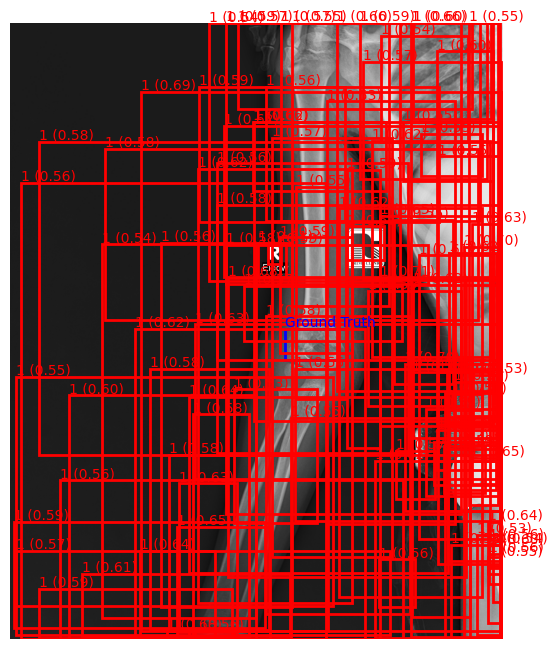

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
from PIL import Image

def plot_image_with_boxes(img, original_boxes, predicted_boxes, predicted_scores, labels, class_names=None):

    if isinstance(img, torch.Tensor):
        img = F.to_pil_image(img)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Draw original bbox
    for box in original_boxes:
        x_min, y_min, x_max, y_max = box.tolist()
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='blue', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min - 10, "Ground Truth", color='blue', fontsize=10)

    # Draw predicted bbox
    for box, score, label in zip(predicted_boxes, predicted_scores, labels):
        x_min, y_min, x_max, y_max = box.tolist()
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        label_text = f"{class_names[label] if class_names else label} ({score:.2f})"
        ax.text(x_min, y_min - 10, label_text, color='red', fontsize=10)

    plt.axis('off')
    plt.show()

#Plotting a single image with its bounding boxes
for imgs, targets in train_loader:
    imgs = [img.to(device) for img in imgs]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Get predictions
    outputs = model(imgs)

    for i, output in enumerate(outputs):
        img = imgs[i].cpu()
        original_boxes = targets[i]['boxes'].cpu()
        predicted_boxes = output['boxes'].cpu()
        predicted_scores = output['scores'].cpu()
        predicted_labels = output['labels'].cpu()

        # Display the image with bounding boxes
        plot_image_with_boxes(
            img,
            original_boxes,
            predicted_boxes,
            predicted_scores,
            predicted_labels,
            class_names=None  # Replace with your class names if available
        )
        break  # Display only the first image for demonstration
    break


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # fractured and non-fractured
# Replace the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [ ]:
import torch
import torch.optim as optim

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Epoch [1/20], Training Loss: 0.2583, Validation Loss: 0.2026
Model saved at: checkpoints/epoch_1.pth
Epoch [2/20], Training Loss: 0.2313, Validation Loss: 0.2031
Model saved at: checkpoints/epoch_2.pth
Epoch [3/20], Training Loss: 0.1970, Validation Loss: 0.2076
Model saved at: checkpoints/epoch_3.pth
Epoch [4/20], Training Loss: 0.1565, Validation Loss: 0.2102
Model saved at: checkpoints/epoch_4.pth
Epoch [5/20], Training Loss: 0.1399, Validation Loss: 0.2194
Model saved at: checkpoints/epoch_5.pth
Epoch [6/20], Training Loss: 0.1309, Validation Loss: 0.2246
Model saved at: checkpoints/epoch_6.pth
Epoch [7/20], Training Loss: 0.1220, Validation Loss: 0.2251
Model saved at: checkpoints/epoch_7.pth
Epoch [8/20], Training Loss: 0.1207, Validation Loss: 0.2231
Model saved at: checkpoints/epoch_8.pth
Epoch [9/20], Training Loss: 0.1191, Validation Loss: 0.2262
Model saved at: checkpoints/epoch_9.pth
Epoch [10/20], Training Loss: 0.1186, Validation Loss: 0.2259
Model saved at: checkpoints/e

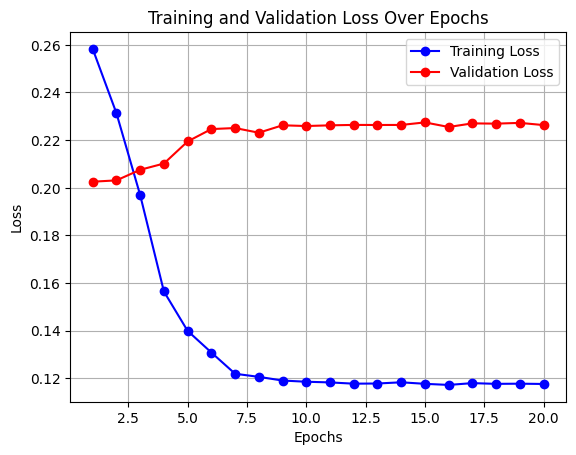

In [ ]:
#Training
import torch
import matplotlib.pyplot as plt
import os


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Ensure the checkpoints directory exists
os.makedirs('checkpoints', exist_ok=True)


train_losses = []
val_losses = []

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

    # Training loop
    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_train_loss += losses.item()

    # Average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Switch temporarily to training mode to compute loss
            model.train()  # Enable training mode for loss computation
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            model.eval()  # Switch back to evaluation mode

            epoch_val_loss += losses.item()

    # Average validation loss for the epoch
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)


    # Step the learning rate scheduler
    lr_scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save the model at the end of each epoch

    checkpoint_path = f"checkpoints/epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model saved at: {checkpoint_path}")

# Plot the training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', color='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-38-186559cf2983>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


IoU for checkpoints/epoch_1.pth: 0.1331
IoU for checkpoints/epoch_2.pth: 0.1495
IoU for checkpoints/epoch_3.pth: 0.1620
IoU for checkpoints/epoch_4.pth: 0.2491
IoU for checkpoints/epoch_5.pth: 0.2908
IoU for checkpoints/epoch_6.pth: 0.3062
IoU for checkpoints/epoch_7.pth: 0.3105
IoU for checkpoints/epoch_8.pth: 0.3143
IoU for checkpoints/epoch_9.pth: 0.3123
IoU for checkpoints/epoch_10.pth: 0.3133
IoU for checkpoints/epoch_11.pth: 0.3149
IoU for checkpoints/epoch_12.pth: 0.3154
IoU for checkpoints/epoch_13.pth: 0.3154
IoU for checkpoints/epoch_14.pth: 0.3144
IoU for checkpoints/epoch_15.pth: 0.3161
IoU for checkpoints/epoch_16.pth: 0.3161
IoU for checkpoints/epoch_17.pth: 0.3161
IoU for checkpoints/epoch_18.pth: 0.3161
IoU for checkpoints/epoch_19.pth: 0.3161
IoU for checkpoints/epoch_20.pth: 0.3161


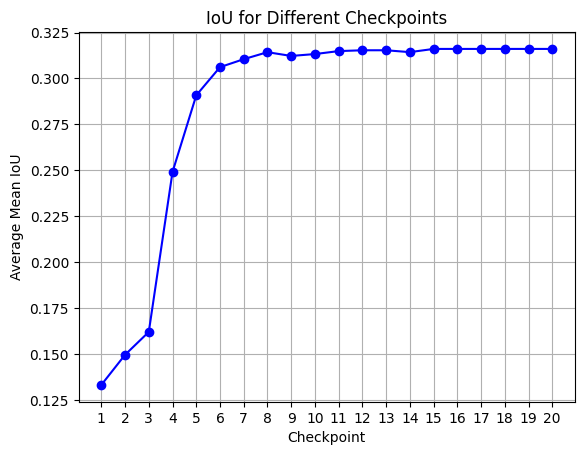

In [ ]:
# Number of classes and device setup
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model.to(device)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Compute mean IoU for a given checkpoint
def compute_mean_iou_for_checkpoint(checkpoint_path, val_loader):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    mean_ious = []

    with torch.no_grad():
        for imgs, targets in val_loader:  # Use the validation loader
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass to get predictions
            outputs = model(imgs)

            for i in range(len(outputs)):  # Process each image in the batch
                pred_boxes = outputs[i]['boxes'].cpu().numpy()  # Predicted bounding boxes
                gt_boxes = targets[i]['boxes'].cpu().numpy()    # Ground truth bounding boxes

                if len(pred_boxes) > 0 and len(gt_boxes) > 0:  # Ensure there are boxes to compare
                    # Calculate IoU between predicted and ground truth boxes
                    iou_matrix = box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))

                    # Average all IoUs for this image
                    mean_iou = iou_matrix.mean().item()
                    mean_ious.append(mean_iou)

    # Calculate the average mean IoU across all images in the test set
    if mean_ious:
        avg_mean_iou = np.mean(mean_ious)
        return avg_mean_iou
    else:
        return 0

# List of 20 weight file paths
checkpoint_files = [f"checkpoints/epoch_{i}.pth" for i in range(1, 21)]


# Loop over and compute IoU for each checkpoint
ious = []
for checkpoint_path in checkpoint_files:
    avg_mean_iou = compute_mean_iou_for_checkpoint(checkpoint_path, val_loader)
    ious.append(avg_mean_iou)
    print(f"IoU for {checkpoint_path}: {avg_mean_iou:.4f}")

# Plot the IoU scores for all 10 checkpoints
plt.plot(range(1, 21), ious, marker='o', linestyle='-', color='b')
plt.title('IoU for Different Checkpoints')
plt.xlabel('Checkpoint')
plt.ylabel('Average Mean IoU')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()


In [ ]:
#Load model with best weight

num_classes = 2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the saved weights, skipping the box predictor
checkpoint_path = "checkpoints/epoch_15.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
state_dict = checkpoint

# Load the modified state_dict
model.load_state_dict(state_dict, strict=False)

print(f"Model weights loaded successfully from {checkpoint_path}")



Model weights loaded successfully from checkpoints/epoch_15.pth


<ipython-input-39-003e833f1858>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [ ]:
dataset_test = CustomCOCODataset(fractured_image_dir, annotation_file_test, transforms=F.to_tensor)
test_loader = DataLoader(dataset_test, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as F

def visualize_boxes(img, original_boxes, predicted_boxes, predicted_scores, predicted_labels, class_names=None):

    if isinstance(img, torch.Tensor):
        img = F.to_pil_image(img)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Draw original bounding boxes in blue
    for box in original_boxes:
        x_min, y_min, x_max, y_max = box.tolist()
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='blue', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min - 10, "Ground Truth", color='blue', fontsize=10)

    # Draw predicted bounding boxes in red
    for box, score, label in zip(predicted_boxes, predicted_scores, predicted_labels):
        x_min, y_min, x_max, y_max = box.tolist()
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        label_text = f"{class_names[label] if class_names else label} ({score:.2f})"
        ax.text(x_min, y_min - 10, label_text, color='red', fontsize=10)

    plt.axis('off')
    plt.show()


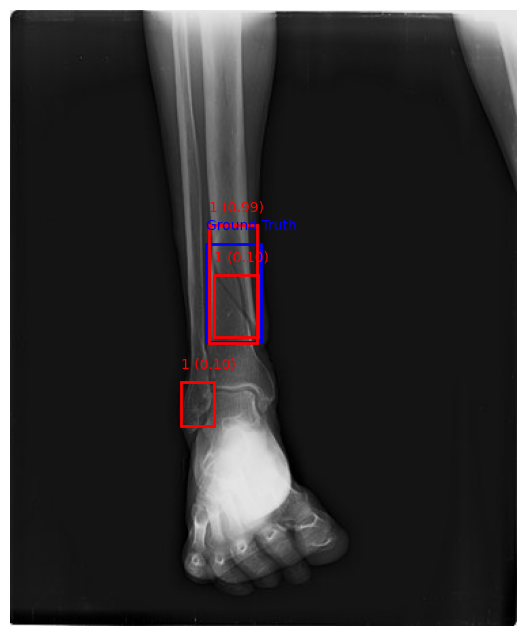

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Get predictions
        outputs = model(imgs)

        for i, output in enumerate(outputs):
            img = imgs[i].cpu()
            original_boxes = targets[i]['boxes'].cpu()
            predicted_boxes = output['boxes'].cpu()
            predicted_scores = output['scores'].cpu()

            # Custom model does NOT return labels yet
            predicted_labels = torch.zeros(len(predicted_boxes), dtype=torch.int64)

            plot_image_with_boxes(
                img,
                original_boxes,
                predicted_boxes,
                predicted_scores,
                predicted_labels,
                class_names=None
            )
            break
        break

Average Mean IoU across all test images: 0.2752


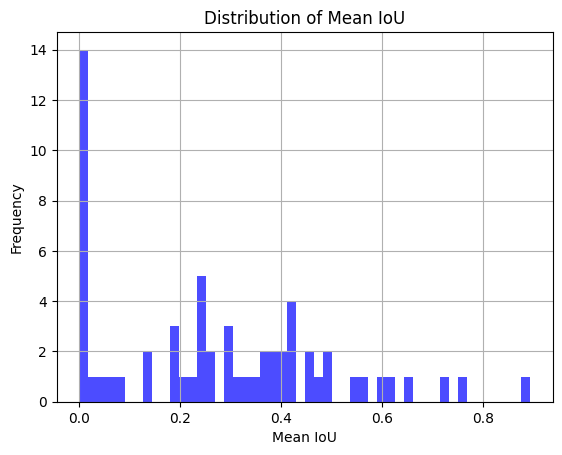

In [ ]:
mean_ious = []

# Running on the test set and calculate IoU
model.eval()
with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass to get predictions
        outputs = model(imgs)

        for i in range(len(outputs)):
            pred_boxes = outputs[i]['boxes'].cpu().numpy()
            gt_boxes = targets[i]['boxes'].cpu().numpy()


            # Calculate IoU between all predicted and ground truth boxes
            iou_matrix = box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))

            # Include IoU of 0
            unmatched_pred_ious = [0] * (len(pred_boxes) - iou_matrix.size(0))
            unmatched_gt_ious = [0] * (len(gt_boxes) - iou_matrix.size(1))

            all_ious = iou_matrix.flatten().tolist() + unmatched_pred_ious + unmatched_gt_ious
            mean_iou = np.mean(all_ious)

            mean_ious.append(mean_iou)




avg_mean_iou = np.mean(mean_ious)
print(f"Average Mean IoU across all test images: {avg_mean_iou:.4f}")



plt.hist(mean_ious, bins=50, alpha=0.7, color='blue')
plt.title("Distribution of Mean IoU")
plt.xlabel("Mean IoU")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Mean Average Precision (mAP): 0.3810
precision: 0.4376
recall: 0.4520


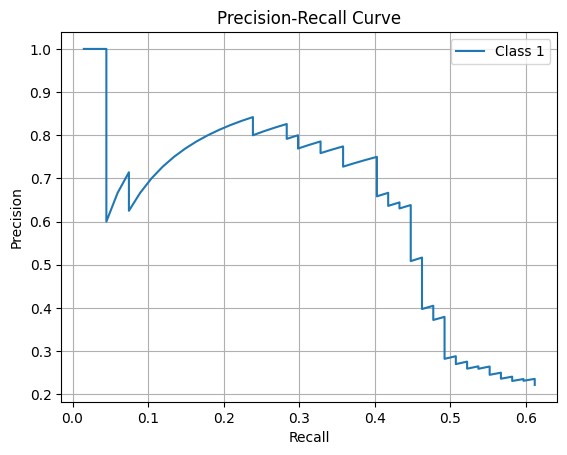

In [ ]:
# Calculate mAP
iou_threshold = 0.5
num_classes = 2

all_detections = {cls: {'tp': [], 'fp': [], 'scores': []} for cls in range(num_classes)}
all_gts = {cls: [] for cls in range(num_classes)}

# Run on test set
model.eval()
with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Get predictions
        outputs = model(imgs)

        for i in range(len(outputs)):
            pred_boxes = outputs[i]['boxes'].cpu().numpy()  # Predicted bounding boxes
            pred_scores = outputs[i]['scores'].cpu().numpy()  # Predicted scores
            pred_labels = outputs[i]['labels'].cpu().numpy()  # Predicted class labels

            gt_boxes = targets[i]['boxes'].cpu().numpy()    # Gt bounding boxes
            gt_labels = targets[i]['labels'].cpu().numpy()  # Gt class labels

            for label in range(num_classes):
                pred_class_boxes = pred_boxes[pred_labels == label]
                pred_class_scores = pred_scores[pred_labels == label]
                gt_class_boxes = gt_boxes[gt_labels == label]

                # Compute IoU for each pair of predicted and gt boxes
                iou_matrix = box_iou(torch.tensor(pred_class_boxes), torch.tensor(gt_class_boxes))

                # Check if it's a TP or FP based on IoU threshold
                for j, pred_box in enumerate(pred_class_boxes):
                    iou_values = iou_matrix[j]  # IoU values with all ground truth boxes for this prediction
                    max_iou = iou_values.max().item()

                    if max_iou >= iou_threshold:  # If the IoU exceeds the threshold, it's a TP. Otherwise, it's a FP
                        all_detections[label]['tp'].append(1)
                        all_detections[label]['fp'].append(0)
                    else:
                        all_detections[label]['tp'].append(0)
                        all_detections[label]['fp'].append(1)

                    all_detections[label]['scores'].append(pred_scores[j])

                # Count the ground truth boxes for the current class
                all_gts[label].extend([1] * len(gt_class_boxes))


mean_average_precisions = []

for cls in range(num_classes):
    if len(all_gts[cls]) == 0:  # Skip classes with no ground truth instances
        continue

    # Sort detections by score
    detections = sorted(zip(all_detections[cls]['scores'], all_detections[cls]['tp'], all_detections[cls]['fp']),
                        key=lambda x: x[0], reverse=True)

    # Extract sorted values
    sorted_scores, sorted_tp, sorted_fp = zip(*detections)

    # Compute cumulative TP and FP counts
    cum_tp = np.cumsum(sorted_tp)
    cum_fp = np.cumsum(sorted_fp)

    # Compute precision and recall
    precision = cum_tp / (cum_tp + cum_fp + 1e-6)
    recall = cum_tp / (len(all_gts[cls]) + 1e-6)

    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)

    # Compute average precision by integrating the precision-recall curve
    # Calculate the area under the precision-recall curve
    ap = np.trapz(precision, recall)
    mean_average_precisions.append(ap)

# Compute mAP: mean of AP values for all classes
mAP = np.mean(mean_average_precisions)
print(f"Mean Average Precision (mAP): {mAP:.4f}")
print(f"precision: {mean_precision:.4f}")
print(f"recall: {mean_recall:.4f}")


plt.plot(recall, precision, label=f'Class {cls}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


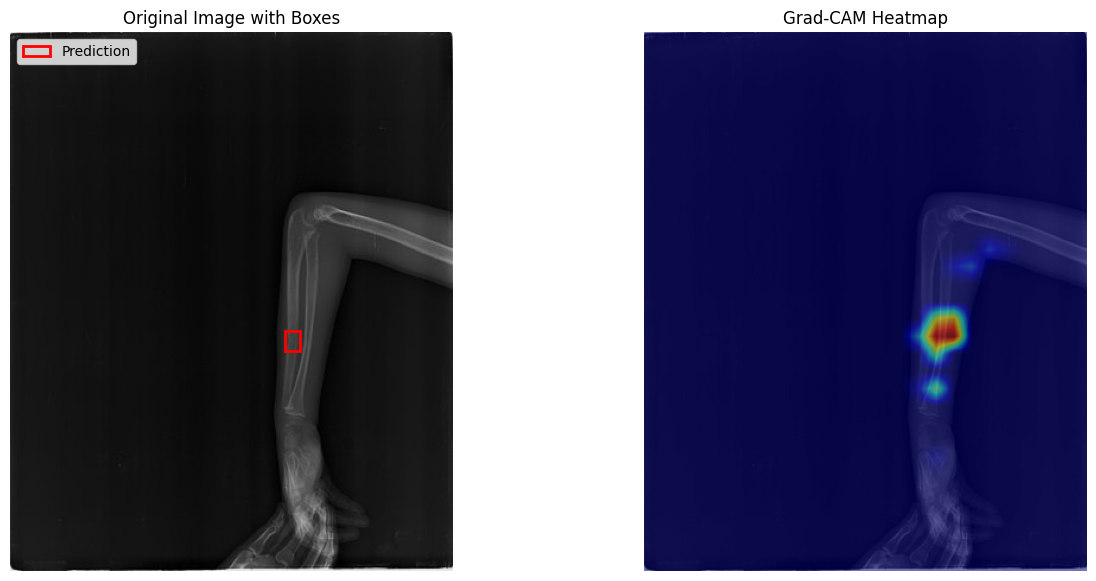

In [ ]:
import torchvision.transforms.functional as F
from PIL import Image
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms.functional import to_pil_image
import matplotlib.patches as patches

# Load the image
image_path = '/content/drive/My Drive/project8980/FracAtlas/images/Fractured/IMG0002086.jpg'
image = Image.open(image_path).convert("RGB")  # Convert to RGB

# Transform the image to a tensor
img_tensor = F.to_tensor(image).to(device).unsqueeze(0)  # Add batch dimension

# Define hooks
feature_maps = []
gradients = []

def forward_hook(module, input, output):
    feature_maps.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])


target_layer = model.backbone.body.layer4[-1]  # Last layer of ResNet50
hook = target_layer.register_forward_hook(forward_hook)
grad_hook = target_layer.register_backward_hook(backward_hook)


img_list = [img_tensor.squeeze(0)]  # Remove batch dimension

# Forward pass
outputs = model(img_list)


scores = outputs[0]['scores']
boxes = outputs[0]['boxes']
target_idx = torch.argmax(scores)  # Index of highest score
target_box = boxes[target_idx]


# Backward pass to calculate gradients
loss = scores[target_idx]  # Use the score of the selected box
model.zero_grad()
loss.backward()

if gradients and feature_maps:
    # Get the feature map and gradient
    feature_map = feature_maps[0][0]  # First image in batch
    gradient = gradients[0][0]

    # Compute weights
    weights = gradient.mean(dim=(1, 2), keepdim=True)  # Average over spatial dimensions

    # Compute Grad-CAM
    cam = (weights * feature_map).sum(dim=0).detach().cpu().numpy()  # Detach before converting to numpy

    # Normalize CAM to [0, 1]
    cam = np.maximum(cam, 0)  # ReLU to remove negative values
    if cam.max() != 0:  # Avoid division by zero
        cam = cam / cam.max()

    # Resize Grad-CAM to match input image size
    cam_resized = cv2.resize(cam, (img_tensor.shape[-1], img_tensor.shape[-2]))

    # Convert original image tensor to PIL format
    original_image = to_pil_image(img_tensor.squeeze().cpu())

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Overlay heatmap on the original image
    overlayed_image = cv2.addWeighted(np.array(original_image), 0.5, heatmap, 0.5, 0)

    # Plot the images with bounding boxes
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Plot the original image with ground truth and predicted box
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image with Boxes")
    ax[0].axis("off")



    # Add predicted box in red
    x_min, y_min, x_max, y_max = target_box.detach().cpu().numpy()
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                              linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
    ax[0].add_patch(rect)

    ax[0].legend(loc="upper left")

    # Plot the heatmap overlay
    ax[1].imshow(overlayed_image)
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis("off")

    plt.show()

# Remove hooks to avoid memory leaks
hook.remove()
grad_hook.remove()
